In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from sklearn.decomposition import *

<br>

# Description of PCA
---

<br> 

### The principle

We have a design matrix $X$ (each of the $n$ row is a data point of dimension $d$) of dimension $\mathcal{R}^{n \times d}$. We look for a transformation of the inputs from dimension $d$ to dimension $m$, such that $m \ll d$, but we keep most of the information of the data.

The **manifold hypothesis** states that most of the data lies a lower dimension sub-space. If we further consider this sub-space to be an hyperplane of the original space, PCA can be used. The goal is to identify the **sub-space along which we have most variance**. Why? Because it is the signature of the manifold we are looking for: no variances along the other axis thare are not used.

We therefore look for a linear transformation $W$ of dimension $\mathcal{R}^{d \times m}$:

* The new data will be $T = XW$ of dimension $\mathcal{R}^{n \times m}$
* The new features will be ordered by decreasing variance along the dimension

Recall that matrix multiplication is:

&emsp; $T_{ij} = (XW)_{ij} = row(X,i)^T col(W,j)$
&emsp; $\implies$
&emsp; $T_{ij} = x_i^T w_j$
&emsp; where
&emsp; $W = (w_1, w_2 \dots w_m)$

We therefore see that **the vectors $w_i$ are selected vectors of dimension $d$ in the original space along which the data $X$ will be projected.**

<br>

### How to proceed - general idea

We can proceed recursively:

1. Identify the axis (vector $w_1$) along which the data has the most variance
2. Project the data $X$ to this axis ($X w_1$ will given the first column of the new matrix $T$)
3. Remove this projection to all data point (so next $w_i$ are orthogonal to previous $w_{j<i})$
4. Recurse (try to find the next dimension with the most variance)

The variance of a data set is given by (assuming $X$ is centered on zero):

&emsp; $\sigma^2[X] = \frac{1}{N} \sum_n x_n x_n^T = \frac{1}{N} X^T X = S$
&emsp;
&emsp; (with $S$ symmetric and positive definite)

The variance along one dimension is simply:

&emsp; $\sigma^2[X w_i] = \frac{1}{N} \sum_n (x_n^T w_i)^T (x_n^T w_i) = \frac{1}{N} \sum_n w_i^T x_n x_n^T w_i = w_i^T S w_i$

We know that $S$ is symmetric and definite positive. This implies that $S$ has positive real eigenvalues. We can simply **align $w_i$ with the eigenvector associated to the highest eigenvalue**. It is easy to see that this is the best axis we can select.

We can derive the same result (the fact that $w_i$ needs to be an eigenvector) differently, by using constraint optimization. We build a Langrangian $\mathcal{L}$ to encode the constraint that $w_i$ should be a unit vector, and maximize this value:

&emsp; $\mathcal{L}(w,\lambda) = w^T S w - \lambda (w^T w - 1)$
&emsp; $\implies$
&emsp; $\displaystyle \frac{\partial L}{\partial w} = S w - \lambda w = 0$
&emsp; $\implies$
&emsp; $S w = \lambda w$ ($w$ is an eigenvector)

The general idea is therefore the following: do the eigen decomposition of the covariance matrix $S$ and pick the eigen vectors corresponding to the highest eigen values. The resulting values $t_n^T = x_n^T W$ will correspond to the projections of $x_n$ with the highest remaining variance (and therefore by assumption, with the most information).

<br>

### First algorithm (eigen decomposition of the covariance matrix)

Compute $S = X^T X$ and decomposite it in eigen values $S = V \Lambda V^T$ where $V = (v_1, \dots v_n)$ are the orthogonal eigenvectors of $S$.

We now pick a sub-selection of the $m < d$ eigenvectors of size $d$ of $V$ to form a matrix $W$. We pick these vectors such that their eigen values are maximum. The new data is obtained by multiplying the design matrix $X$ by $W$, which means projecting the data along these selected axis:

&emsp; $T = XW \in \mathcal{R}^{p \times l}$

**Side note:** the expression $S = V \Lambda V^T$ can be reworked as $V^T X^T X V = \Lambda = (X V)^T X V = T^T T$. So we see that there exists an orthogonal transformation $T = XV$ such that each axis is independent (no covariance).

**Important note:** The covariance only find linear (not even affine) relationships. This means the data must be centered in order for it to work. It also means that each axis is **independent for linear relationships** (it does not work for other kind of relationships).

In [15]:
# Simple example with clearly correlated features
X = np.array([
    [-1., 2.],
    [ 0., 0.],
    [ 1, -2.]])

# Decompose the covariance matrix
eigen_values, eigen_vectors = np.linalg.eig(X.T @ X)

# Sort the eigen values by descending eigen values, and keep the first
descending_indices = np.argsort(eigen_values)[::-1]
W = eigen_vectors[:,descending_indices[:1]]

# Project the data in this new space
T = X @ W
print(T)

# Alternatively, we could use Scikit-learn to do this for us
pca = PCA(n_components=1)
print(pca.fit_transform(X))

[[-2.23606798]
 [ 0.        ]
 [ 2.23606798]]
[[-2.23606798]
 [ 0.        ]
 [ 2.23606798]]


<br>

### Second algorithm (SVD decomposition)

All matrices can be decomposed like $X = U \Sigma V^T$ where $V$ are the orthogonal eigenvectors of $X^T X$, $U$ are the orthogonal eigenvectors of $X X^T$, and $\Sigma$ is a diagonal matrix (stretching matrix) of **singular values** where $\lambda_i = \sigma_i^2$ are the eigenvalues of $X^T X$.

So we can use SVD decomposition, and sort the singular values in decreasing order, and then select the $m < d$ eigenvectors associated to the highest eigenvalues of $V$ to create $W$.

In [14]:
# Compute the svd decomposition of X
u, s, v_t = np.linalg.svd(X)

# Sort the eigen values by descending eigen values, and keep the first
descending_indices = np.argsort(s)[::-1]
W = v_t.T[:,descending_indices[:1]]

# Print the transformed matrix
T = X @ W
print(T)

[[-2.23606798]
 [ 0.        ]
 [ 2.23606798]]


<br>

# Limits of PCA
---

The naive PCA is computationally intensive (due to the eigen value decomposition and the matrix multiplication to get the covariance matrix).

PCA is limited to find linear relationships, due to the definition of covariance between two variables: $E[(X_i - \bar{X_i})(X_j - \bar{X_j})]$ and more generally the fact that we work with linear functions (eigen vectors, orthogonal rotation matrix).

**Example:**

* In polar coordinates $\rho e^{i\theta}$, the data has low variance for $\rho$, but high variance for $\theta$
* If we had to keep an axis, it would be the axis for $\theta$, but in the cartesian coordinates, PCA cannot do this

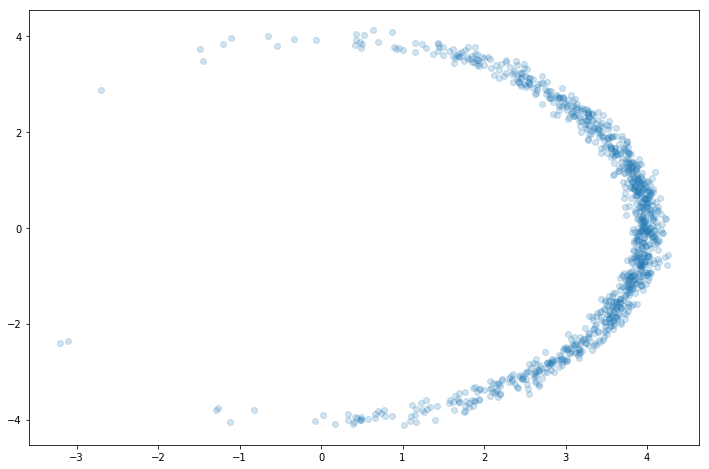

In [4]:
polars = np.random.multivariate_normal(
    mean=np.array([4.0, 0.0]),
    cov=np.array([[0.01, 0.0], [0.0, 0.5]]),
    size=1000)

def transform(cluster):
    xs = cluster[:,0] * np.cos(cluster[:,1])
    ys = cluster[:,0] * np.sin(cluster[:,1])
    return np.concatenate([np.expand_dims(xs, -1), np.expand_dims(ys, -1)], axis=1)

X = transform(polars)

plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plt.show()

We can lift this limitations by first transforming our data into another vector space that makes the relations between variable appear linear. This is typically done by projecting in higher dimensions.

Here we illustrate what it does with a transformation from cartesian coordinates back to polar coordinates (so that it stays in 2D and is drawable), but in the general case:

1. we do not know which transformation to apply
2. we do not care about the reverse projection

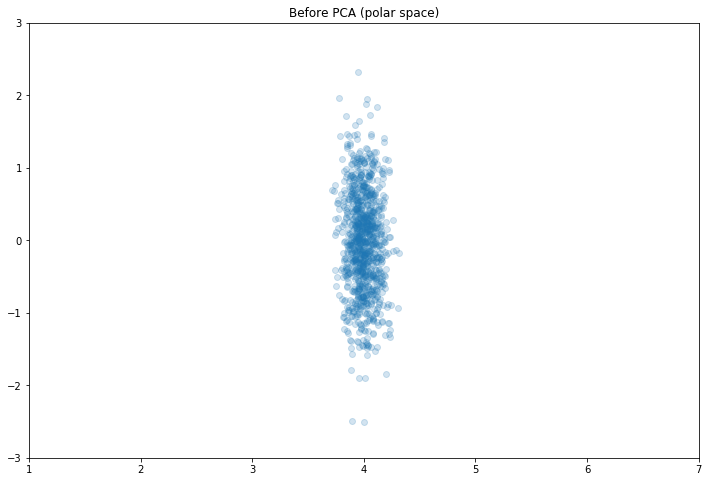

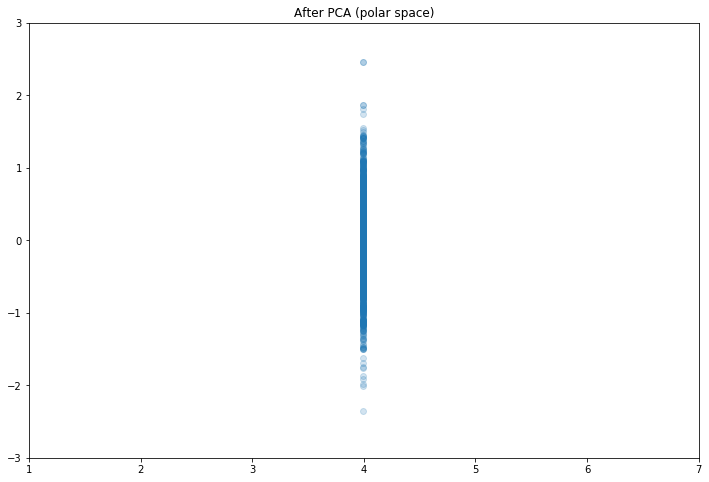

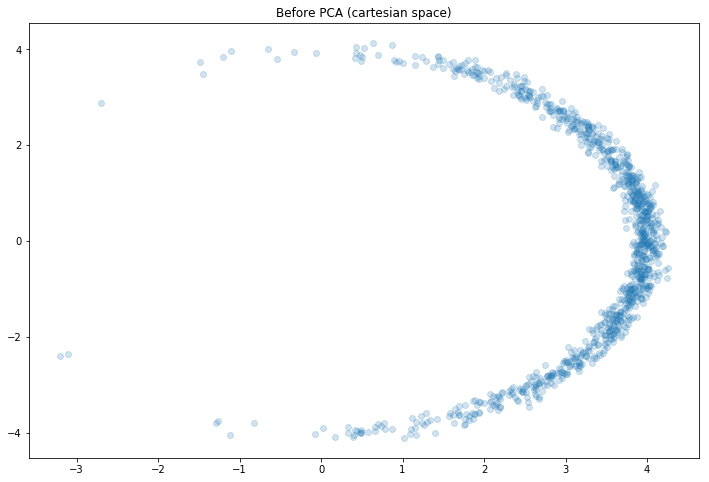

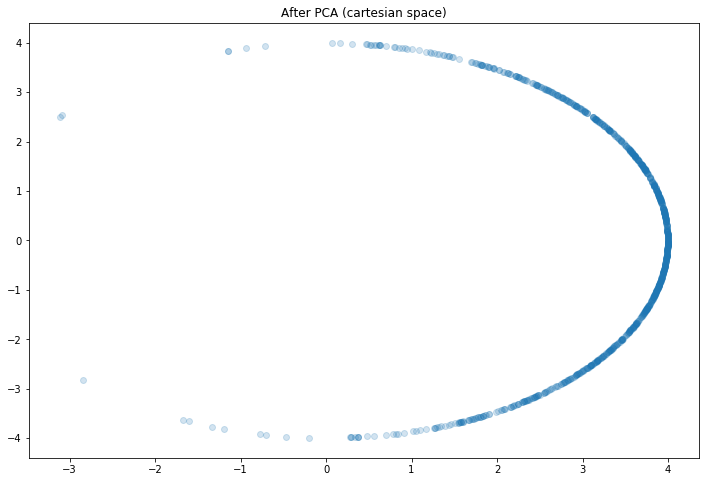

In [5]:
# The projection in different space
def project(cluster):
    norms = np.sqrt(cluster[:,0] ** 2 + cluster[:,1] ** 2)
    theta = np.arctan2(cluster[:,1], cluster[:,0])
    return np.concatenate([np.expand_dims(norms, -1), np.expand_dims(theta, -1)], axis=1)
    

# Show the result of the projection
T = project(X)
plt.figure(figsize=(12, 8))
plt.scatter(T[:,0], T[:,1], alpha=0.2)
plt.xlim(1, 7)
plt.ylim(-3, 3)
plt.title("Before PCA (polar space)")
plt.show()


# Remove the means in the projected space
feature_means = np.mean(T, axis=0)
T = T - feature_means


# Extract the principal components
pca = PCA(n_components=1)
T2 = pca.fit_transform(T)

plt.figure(figsize=(12, 8))
plt.scatter(np.full(fill_value=feature_means[0], shape=T2.shape), feature_means[1] + T2, alpha=0.2)
plt.xlim(1, 7)
plt.ylim(-3, 3)
plt.title("After PCA (polar space)")
plt.show()


# Show the result on the main space
X2 = transform(np.concatenate([np.full(fill_value=feature_means[0], shape=T2.shape), feature_means[1] + T2], axis=1))

plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plt.title("Before PCA (cartesian space)")
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(X2[:,0], X2[:,1], alpha=0.2)
plt.title("After PCA (cartesian space)")
plt.show()

**Important notes:**
* the graphical illustrations are in 2D here in order to explain visually the effect of PCA, but in reality, one of the dimension has been completely removed (and we just have 1D)
* the alignment along the directions of the axis here is not necessary: PCA will find rotations if necessary

<br>

# Kernel PCA
---

The idea of transforming in a higher dimensional space is useful, but leads to more involved computations, since the number of dimension is higher. We can make use of the kernel trick to limit the amount of computations.

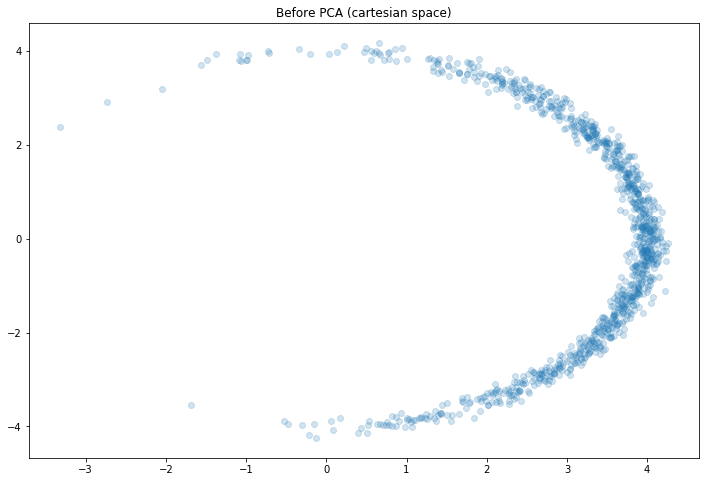

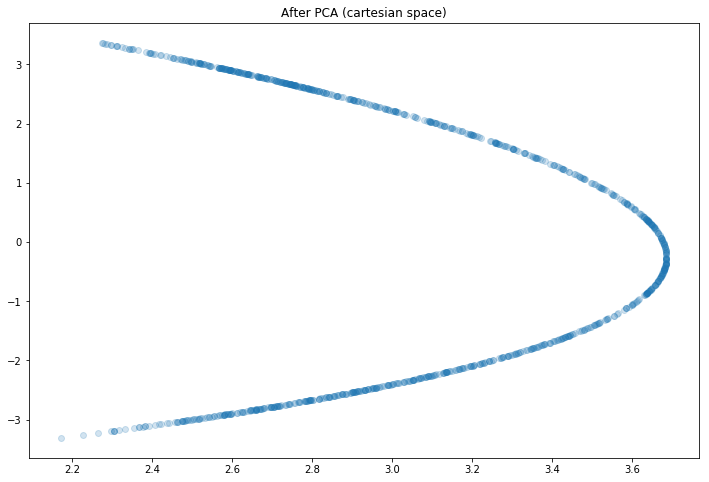

In [6]:
polars = np.random.multivariate_normal(
    mean=np.array([4.0, 0.0]),
    cov=np.array([[0.01, 0.0], [0.0, 0.5]]),
    size=1000)

def transform(cluster):
    xs = cluster[:,0] * np.cos(cluster[:,1])
    ys = cluster[:,0] * np.sin(cluster[:,1])
    return np.concatenate([np.expand_dims(xs, -1), np.expand_dims(ys, -1)], axis=1)

X = transform(polars)

pca = KernelPCA(kernel='poly', n_components=1, fit_inverse_transform=True)
T = pca.fit_transform(X)

X2 = pca.inverse_transform(T)

plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plt.title("Before PCA (cartesian space)")
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(X2[:,0], X2[:,1], alpha=0.2)
plt.title("After PCA (cartesian space)")
plt.show()

Now, there is a degradation that we can witness when we reconstruct the data.

However, PCA is often used as a first dimensionality reduction technique in order to solve a specific task. Ultimately, the quality of the transformation / dimensionnality reduction can only be assessed by checking whether or not the task we are interested in is still solvable with the same accuracy after the transformation.

# Auto-encoders
---

Link with compression
Link with latent variables?

801.1436995863914
487.58760356903076
444.9626889228821
331.0919835269451
193.38943894207478
88.51047536730766
51.583921135403216
38.10559966415167
28.67511417903006
20.909152247942984
16.52400872251019
13.659721196163446
10.932511321268976
9.45642564469017
7.759260995313525


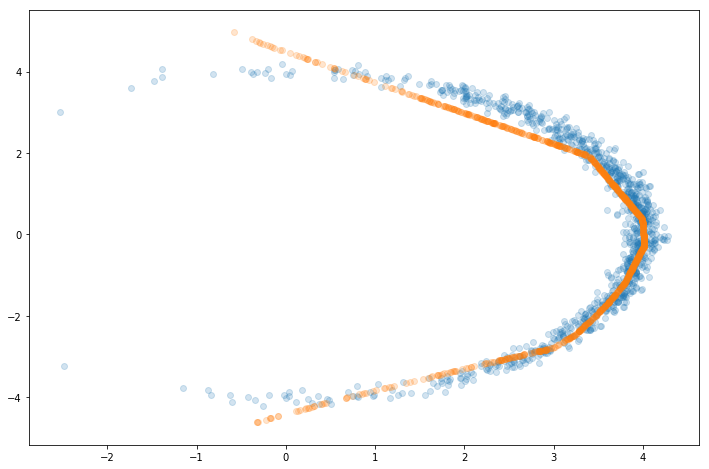

In [16]:
polars = np.random.multivariate_normal(
    mean=np.array([4.0, 0.0]),
    cov=np.array([[0.01, 0.0], [0.0, 0.5]]),
    size=1000)

def transform(cluster):
    xs = cluster[:,0] * np.cos(cluster[:,1])
    ys = cluster[:,0] * np.sin(cluster[:,1])
    return np.concatenate([np.expand_dims(xs, -1), np.expand_dims(ys, -1)], axis=1)

X = transform(polars)


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(2, 32), nn.ReLU(), nn.Linear(32, 1))
        self.decoder = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 2))
    
    def forward(self, xs):
        return self.decoder(self.encoder(xs))
    
    def encode(self, xs):
        return self.encoder(xs)
    
    def decode(self, xs):
        return self.decoder(xs)


model = AutoEncoder()

model.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
ds = data.TensorDataset(torch.FloatTensor(X))
loader = data.DataLoader(ds, shuffle=True, batch_size=5)

for _ in range(15):
    episode_loss = 0.
    for [x] in loader:
        y = model(x)
        loss = criterion(y, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        episode_loss += loss.item()
    print(episode_loss)


model.eval() 
Y = model(torch.FloatTensor(X)).detach().numpy()


plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plt.scatter(Y[:,0], Y[:,1], alpha=0.2)
plt.show()